In [9]:
import pandas as pd
import numpy as np

df1 = pd.read_csv("olist_customers_dataset.csv")
df2 =  pd.read_csv("olist_geolocation_dataset.csv")
df3 =  pd.read_csv("olist_order_items_dataset.csv")
df4 =  pd.read_csv("olist_order_payments_dataset.csv")
df5 =  pd.read_csv("olist_order_reviews_dataset.csv")
df6 =  pd.read_csv("olist_orders_dataset.csv")
df7 =  pd.read_csv("olist_products_dataset.csv")
df8 =  pd.read_csv("olist_sellers_dataset.csv")
df9 =  pd.read_csv("product_category_name_translation.csv")

In [12]:
import pandas as pd
import numpy as np

# 1. 데이터 통합 (df1~df9가 이미 로드된 상태여야 합니다)
# 아이템 + 주문 + 셀러 + 제품 + 영어번역 + 리뷰
m1 = pd.merge(df3, df6[['order_id', 'order_delivered_customer_date']], on='order_id', how='left')
m2 = pd.merge(m1, df8[['seller_id', 'seller_state']], on='seller_id', how='left')
m3 = pd.merge(m2, df7[['product_id', 'product_category_name']], on='product_id', how='left')
df_all = pd.merge(m3, df9, on='product_category_name', how='left')
df_all = pd.merge(df_all, df5[['order_id', 'review_score']], on='order_id', how='left')

# 2. 날짜 변환 및 지연 시간 계산
df_all['order_delivered_customer_date'] = pd.to_datetime(df_all['order_delivered_customer_date'])
df_all['shipping_limit_date'] = pd.to_datetime(df_all['shipping_limit_date'])
df_all['delay'] = (df_all['order_delivered_customer_date'] - df_all['shipping_limit_date']).dt.days

# 결측치 제거
df_clean = df_all.dropna(subset=['delay', 'review_score', 'product_category_name_english']).copy()

# 3. 환경 벤치마크(지역/카테고리 평균) 계산
group_bench = df_clean.groupby(['seller_state', 'product_category_name_english']).agg({
    'delay': 'mean',
    'review_score': 'mean'
}).rename(columns={'delay': 'env_delay_avg', 'review_score': 'env_score_avg'}).reset_index()

# 4. 셀러별 성적 산출
seller_perf = df_clean.groupby(['seller_id', 'seller_state', 'product_category_name_english']).agg({
    'delay': 'mean',
    'review_score': 'mean',
    'order_id': 'count'
}).reset_index()

# 벤치마크 병합 및 Gap 계산
final_analysis = pd.merge(seller_perf, group_bench, on=['seller_state', 'product_category_name_english'])
final_analysis['delay_gap'] = final_analysis['delay'] - final_analysis['env_delay_avg']

# 5. 등급 부여 함수
def get_grade(row):
    if row['review_score'] >= 4.5 and row['delay_gap'] <= 0: return 'S'
    elif row['review_score'] >= 4.0: return 'A'
    elif row['review_score'] >= 3.0: return 'B'
    else: return 'C'

final_analysis['grade'] = final_analysis.apply(get_grade, axis=1)

# 6. 모든 등급별 상위 5명 출력
grades = ['S', 'A', 'B', 'C']
for g in grades:
    print(f"\n--- [Top 5] {g}급 셀러 내역 ---")
    # S, A는 성적이 좋은 순서로, B, C는 그 안에서 상대적으로 나은 순서로 정렬
    top5 = final_analysis[final_analysis['grade'] == g].sort_values(
        by=['review_score', 'delay_gap'], 
        ascending=[False, True]
    ).head(5)
    
    display(top5[['seller_id', 'product_category_name_english', 'review_score', 'delay_gap', 'grade']])


--- [Top 5] S급 셀러 내역 ---


,seller_id,product_category_name_english,review_score,delay_gap,grade
6028,fce62094ffe6a4009188ec44e681dfdd,market_place,5.0,-92.903766,S
5332,e06f09ec0a4aca210779cf1cfc63cf19,bed_bath_table,5.0,-47.397677,S
453,1354d51653f645349064725ed204e85e,art,5.0,-33.698113,S
5251,dd2bdf855a9172734fbc3744021ae9b9,housewares,5.0,-31.232843,S
4630,c3251e13f1bbda6c74e37c160f991e19,furniture_decor,5.0,-30.095091,S



--- [Top 5] A급 셀러 내역 ---


,seller_id,product_category_name_english,review_score,delay_gap,grade
1032,2bd05d410a8fd26dc4184a15f4f2f588,cool_stuff,5.0,0.005376,A
5249,dd2bdf855a9172734fbc3744021ae9b9,costruction_tools_garden,5.0,0.027027,A
5022,d25aa0aaacb370e912f8cf6efeba38b3,construction_tools_construction,5.0,0.054054,A
3924,a08692680c77d30a0b4280da5df01c5a,computers_accessories,5.0,0.057631,A
852,23d7c96d4a1160db1c726b248601b25a,home_appliances,5.0,0.069892,A



--- [Top 5] B급 셀러 내역 ---


,seller_id,product_category_name_english,review_score,delay_gap,grade
4964,cfb1a033743668a192316f3c6d1d2671,bed_bath_table,3.994536,-0.780191,B
3613,92eb0f42c21942b6552362b9b114707d,telephony,3.990909,0.563185,B
761,1f50f920176fa81dab994f9023523100,garden_tools,3.990415,1.728020,B
672,1c68394e931a64f90ea236c5ea590300,computers_accessories,3.987654,-2.440646,B
291,0be8ff43f22e456b4e0371b2245e4d01,sports_leisure,3.985294,-2.450346,B



--- [Top 5] C급 셀러 내역 ---


,seller_id,product_category_name_english,review_score,delay_gap,grade
1914,5058e8c1e82653974541e83690655b4a,office_furniture,2.964286,-3.466426,C
3731,972d0f9cf61b499a4812cf0bfa3ad3c4,bed_bath_table,2.964286,5.762430,C
1112,2eb70248d66e0e3ef83659f71b244378,watches_gifts,2.954955,-0.036522,C
5312,dfa0c4c6229ab200a4a1336b4d7128ff,auto,2.916667,-5.506518,C
4033,a49928bcdf77c55c6d6e05e09a9b4ca5,toys,2.911111,5.703685,C


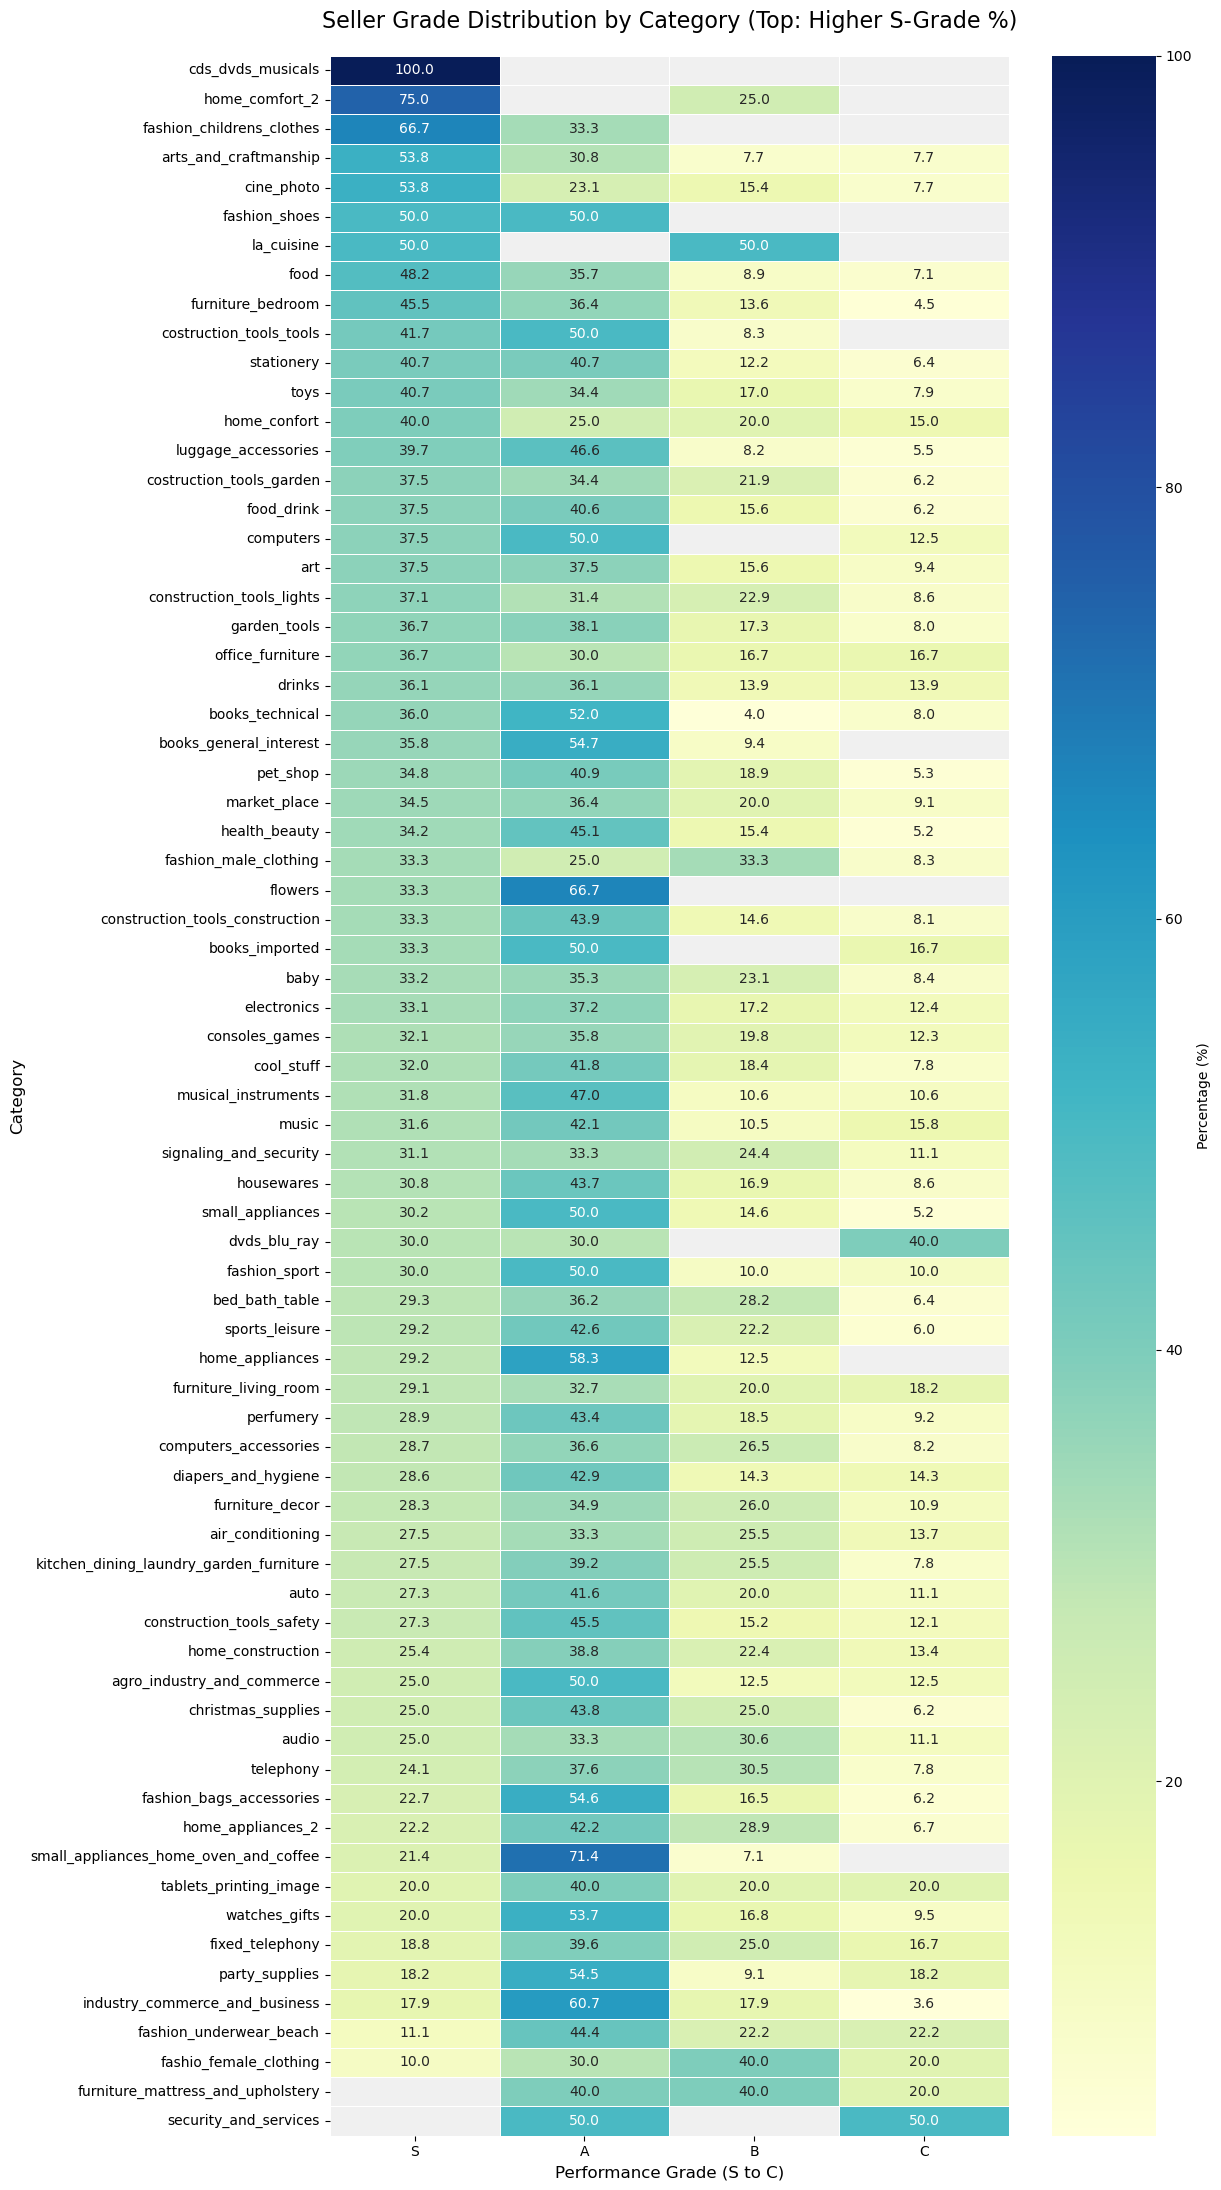

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 시각화용 피벗 테이블 생성
pivot_df = final_analysis.groupby(['product_category_name_english', 'grade']).size().unstack(fill_value=0)

# 2. 비율(%)로 변환
plot_data_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# 3. [오류 방지 및 정렬] 등급 순서를 S-A-B-C로 고정
# 만약 데이터에 특정 등급이 없어도 에러가 나지 않게 처리합니다.
existing_grades = [g for g in ['S', 'A', 'B', 'C'] if g in plot_data_pct.columns]
plot_data_pct = plot_data_pct[existing_grades]

# 4. S등급 비중이 높은 순서로 카테고리 정렬
if 'S' in plot_data_pct.columns:
    plot_data_pct = plot_data_pct.sort_values(by='S', ascending=False)

# 5. [중요] 0을 NaN으로 바꾸되, 시각화 함수에서 na_rep 대신 중립 색상을 사용
plot_data_final = plot_data_pct.replace(0, np.nan)

# 6. 히트맵 시각화 (AttributeError 해결 버전)
plt.figure(figsize=(12, 22))

# na_rep 인자를 제거하고, 대신 masked array 느낌으로 자연스럽게 표현합니다.
sns.heatmap(plot_data_final, 
            annot=True, 
            fmt=".1f", 
            cmap="YlGnBu",      # 수치가 높을수록 진한 파란색
            linewidths=.5, 
            cbar_kws={'label': 'Percentage (%)'},
            mask=plot_data_final.isnull()) # 0(NaN)인 부분은 색을 칠하지 않음

# 바탕색을 아주 연한 회색으로 설정하여 0인 구간을 명확히 구분
plt.gca().set_facecolor('#f0f0f0') 

plt.title('Seller Grade Distribution by Category (Top: Higher S-Grade %)', fontsize=16, pad=20)
plt.xlabel('Performance Grade (S to C)', fontsize=12)
plt.ylabel('Category', fontsize=12)

plt.tight_layout()
plt.show()